In [1]:
# General
import sys
sys.path.insert(0, "../..")

import numpy as np
import numpy_financial as npf
import pandas as pd
import pickle
from matplotlib.ticker import StrMethodFormatter
import matplotlib.pyplot as plt
from functools import partial
from collections import defaultdict
from copy import deepcopy

#FGEM
from fgem.utils.constants import *
from fgem.powerplant import *
from fgem.utils.utils import *
from fgem.utils.config import *
from fgem.world import World

# GEOPHIRES-x
from pathlib import Path
from geophires_x_client import GeophiresXClient
from geophires_x_client.geophires_input_parameters import GeophiresInputParameters

#Override packages
from tqdm.notebook import tqdm

In [2]:
src_dir = "/Users/mohammadaljubran/Desktop/phd/research/code/notebooks/final_test_fgem/"

### Example - A
PercentageDecline, baseload, constant T_amb, constant T_inj, no ramey, compared to geophires

In [ ]:
# https://github.com/NREL/GEOPHIRES-X/blob/main/tests/examples/example1.txt
example_file_path = Path(os.path.join(src_dir, 'geophires_configs/exampleA.txt')).absolute()

client = GeophiresXClient()
result = client.get_geophires_result(
            GeophiresInputParameters(from_file_path=example_file_path)
        )

In [ ]:
def step_update_record(project, m_prd=110, T_amb=15, T_inj=70):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    project.update_state(m_prd)
    project.T_inj = T_inj
    
    # STEP: step power plant and reservoir
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [ ]:
config = get_config_from_json(Path(os.path.join(src_dir, 'fgem_configs/exampleA.json')).absolute())
project = World(config)

for i in tqdm(range(project.max_simulation_steps)):
    step_update_record(project)
    
project.compute_economics()
NPV, ROI, PBP, IRR, PPA_NPV, PPA_ROI, PPA_PBP, PPA_IRR, LCOE, NET_GEN, df_annual = compute_npv(project.df_records, project.capex_total, project.opex_total,
                                                          project.baseline_year, project.L, project.d, ppa_price=75)

# print economics
print(f"LCOE: {LCOE:.0f} $/MWh")
print(f"NPV: {NPV:.0f} $MM")
print(f"ROI: {ROI:.1f} %")
print(f"PBP: {PBP:.0f} yrs")

In [ ]:
include = ['Power Plant', 'Interconnection', 'Exploration', 
           'Drilling', 'Injection Stimulation', 'Gathering System', 'Pumps', 'TES', 'Battery']
costs = {k:v for k,v in project.present_capex_per_unit.items()}
costs["Pumps"] = costs["Production Pumps"] + costs["Injection Pumps"]
costs_final = {k:costs[k] for k in include}
plot_ex({"": costs_final}, figsize=(7,7), dpi=100, fontsize=10)

In [ ]:
include = ['Power Plant', 'Wellsite', 'Makeup Water']
costs = {k:v for k,v in project.present_opex_per_unit.items()}
# costs["Pumps"] = costs["Production Pumps"] + costs["Injection Pumps"]
costs_final = {k:costs[k] for k in include}
plot_ex({"": costs_final}, figsize=(7,7), dpi=100, fontsize=10)

In [ ]:
qdict = {
            "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          'Inj Temp [deg C]': "Intector Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
          "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
#           "Producer Wellhead Pressure + Pinj [bar]": "Producer\nPressure [bar]"
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

span = range(0, project.max_simulation_steps-1)
fig, axes = plot_cols_v2({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False, return_figax=True)

### Example - B1:
Same as above but with changing T_amb, changing T_inj, ramey, daily timestepping

In [ ]:
def step_update_record(project, m_prd=110):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [ ]:
config = get_config_from_json(Path(os.path.join(src_dir, 'fgem_configs/exampleB.json')).absolute())
project = World(config)

for i in tqdm(range(project.max_simulation_steps)):
    step_update_record(project)
    
project.compute_economics()
NPV, ROI, PBP, IRR, PPA_NPV, PPA_ROI, PPA_PBP, PPA_IRR, LCOE, NET_GEN, df_annual = compute_npv(project.df_records, project.capex_total, project.opex_total,
                                                          project.baseline_year, project.L, project.d, ppa_price=75)

# print economics
print(f"LCOE: {LCOE:.0f} $/MWh")
print(f"NPV: {NPV:.0f} $MM")
print(f"ROI: {ROI:.1f} %")
print(f"PBP: {PBP:.0f} yrs")

In [ ]:
qdict = {
            "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          'Inj Temp [deg C]': "Intector Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
          "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
#           "Producer Wellhead Pressure + Pinj [bar]": "Producer\nPressure [bar]"
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

span = range(0, project.max_simulation_steps-1)
fig, axes = plot_cols_v2({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False, return_figax=True)

### Example C
Same as B but with power market data based on 2022 Cambium/E3 RECs, 30% ITC, 30 years lifetime

In [ ]:
def step_update_record(project, m_prd=110):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [ ]:
config = get_config_from_json(Path(os.path.join(src_dir, 'fgem_configs/exampleC.json')).absolute())
project = World(config)

for i in tqdm(range(project.max_simulation_steps)):
    step_update_record(project)
    
project.compute_economics()
NPV, ROI, PBP, IRR, PPA_NPV, PPA_ROI, PPA_PBP, PPA_IRR, LCOE, NET_GEN, df_annual = compute_npv(project.df_records, project.capex_total, project.opex_total,
                                                          project.baseline_year, project.L, project.d, ppa_price=75)

# print economics
print(f"LCOE: {LCOE:.0f} $/MWh")
print(f"NPV: {NPV:.0f} $MM")
print(f"ROI: {ROI:.1f} %")
print(f"PBP: {PBP:.0f} yrs")

In [ ]:
qdict = {
          "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
          "RECs Value [$/MWh]": "RECs\n[$/MWh]",
          "Capacity Value [$/MW-hour]": "Capacity Value \n[$/MWh]",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          'Inj Temp [deg C]': "Intector Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
          "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

span = range(0, project.max_simulation_steps-1)
fig, axes = plot_cols_v2({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False, return_figax=True)

### Example D
Same as C but with analytical DiffusionConvection Reservoir Model

In [ ]:
def step_update_record(project, m_prd=130):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [ ]:
config = get_config_from_json(Path(os.path.join(src_dir, 'fgem_configs/exampleD.json')).absolute())
project = World(config)

for i in tqdm(range(project.max_simulation_steps)):
    step_update_record(project)
    
project.compute_economics()
NPV, ROI, PBP, IRR, PPA_NPV, PPA_ROI, PPA_PBP, PPA_IRR, LCOE, NET_GEN, df_annual = compute_npv(project.df_records, project.capex_total, project.opex_total,
                                                          project.baseline_year, project.L, project.d, ppa_price=75)

# print economics
print(f"LCOE: {LCOE:.0f} $/MWh")
print(f"NPV: {NPV:.0f} $MM")
print(f"ROI: {ROI:.1f} %")
print(f"PBP: {PBP:.0f} yrs")

In [ ]:
qdict = {
#           "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
#           "RECs Value [$/MWh]": "RECs\n[$/MWh]",
#           "Capacity Value [$/MW-hour]": "Capacity Value \n[$/MWh]",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          'Inj Temp [deg C]': "Intector Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
#           "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

span = range(365, project.max_simulation_steps-1)
fig, axes = plot_cols_v2({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False, return_figax=True)

### Example E
Same as D but with power generation maximizing strategy using wellhead throttling and power plant bypass

In [ ]:
def step_update_record(project, max_mass_flow=150):
    
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    power_output_MWh_kg = project.powerplant.power_output_MWh_kg
    required_mass_flow_per_well = project.ppc / (power_output_MWh_kg * 3600 * project.num_prd + SMALL_NUM)
    m_prd = np.minimum(max_mass_flow, np.array(project.num_prd*[required_mass_flow_per_well])).astype(float)
    project.update_state(m_prd)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [ ]:
config = get_config_from_json(Path(os.path.join(src_dir, 'fgem_configs/exampleE.json')).absolute())
project = World(config)

for i in tqdm(range(project.max_simulation_steps)):
    step_update_record(project)
    
project.compute_economics()
NPV, ROI, PBP, IRR, PPA_NPV, PPA_ROI, PPA_PBP, PPA_IRR, LCOE, NET_GEN, df_annual = compute_npv(project.df_records, project.capex_total, project.opex_total,
                                                          project.baseline_year, project.L, project.d, ppa_price=75)

# print economics
print(f"LCOE: {LCOE:.0f} $/MWh")
print(f"NPV: {NPV:.0f} $MM")
print(f"ROI: {ROI:.1f} %")
print(f"PBP: {PBP:.0f} yrs")

In [ ]:
qdict = {
#           "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
#           "RECs Value [$/MWh]": "RECs\n[$/MWh]",
#           "Capacity Value [$/MW-hour]": "Capacity Value \n[$/MWh]",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          'Inj Temp [deg C]': "Intector Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
#           "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

span = range(365, project.max_simulation_steps-1)
fig, axes = plot_cols_v2({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False, return_figax=True)

### Example F
Same D but with slightly higher flow rates and a hot water tank for storage purposes with a diurnal schedule, using 4h timestepping

In [ ]:
def step_update_record(project, m_prd=130, charge_time=(8, 14), discharge_time=(17, 23)):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    if (project.time_curr.hour >= charge_time[0]) and (project.time_curr.hour <= charge_time[1]):
        max_charge_mass = project.st.mass_max_charge/project.timestep.total_seconds()
        m_tes_in = np.clip(m_prd * project.num_prd, 0, max_charge_mass)
        m_tes_out = 0
        m_prd = np.maximum(m_prd, m_tes_in/project.num_prd * np.ones(project.num_prd))
        
    elif (project.time_curr.hour >= discharge_time[0]) and (project.time_curr.hour <= discharge_time[1]):
        max_discharge_mass = project.st.mass_max_discharge/project.timestep.total_seconds()
        m_tes_out = max_discharge_mass
        m_tes_in = 0
        m_prd = np.maximum(m_prd -  m_tes_out/project.num_prd, 10)
        
    else:
        m_tes_in, m_tes_out = 0, 0
        
    project.update_state(m_prd, m_tes_out=m_tes_out, m_tes_in=m_tes_in)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step TES
    m_tes_in, m_tes_out = project.st.step(T_amb, m_tes_in, m_tes_out, T_prd_wh)
    T_tes_out = project.st.Tw
            
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_tes_out=T_tes_out,
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [ ]:
config = get_config_from_json(Path(os.path.join(src_dir, 'fgem_configs/exampleF.json')).absolute())
project = World(config)

for i in tqdm(range(project.max_simulation_steps)):
    step_update_record(project)
    
project.compute_economics()
NPV, ROI, PBP, IRR, PPA_NPV, PPA_ROI, PPA_PBP, PPA_IRR, LCOE, NET_GEN, df_annual = compute_npv(project.df_records, project.capex_total, project.opex_total,
                                                          project.baseline_year, project.L, project.d, ppa_price=75)

# print economics
print(f"LCOE: {LCOE:.0f} $/MWh")
print(f"NPV: {NPV:.0f} $MM")
print(f"ROI: {ROI:.1f} %")
print(f"PBP: {PBP:.0f} yrs")

In [ ]:
qdict = {
#           "LMP [$/MWh]": "Electricity Price \n [$/MWh]",
#           "RECs Value [$/MWh]": "RECs\n[$/MWh]",
#           "Capacity Value [$/MW-hour]": "Capacity Value \n[$/MWh]",
          "TES Temp [deg C]": "TES Temp",
          "TES M_in [kg/s]": "TES M_in",
          "TES M_out [kg/s]": "TES M_out",
          "TES Water Vol [m3]": "TES Vol [m3]",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          'Inj Temp [deg C]': "Intector Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
#           "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

# span = range(365, project.max_simulation_steps-1)
span = range(365, 500)
fig, axes = plot_cols_v2({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False, return_figax=True)

### Example G
Same as D but with battery installed

In [3]:
def step_update_record(project, m_prd=130, charge_time=(10, 14), discharge_time=(17, 21)):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    
    if (project.time_curr.hour >= charge_time[0]) and (project.time_curr.hour <= charge_time[1]):
        max_charge_power = (project.battery.energy_capacity - project.battery.energy_content)/project.timestep_hrs
        p_bat_ppin = np.clip(project.battery_power_capacity[0], 0, max_charge_power)
        p_bat_out = 0
        
    elif (project.time_curr.hour >= discharge_time[0]) and (project.time_curr.hour <= discharge_time[1]):
        max_discharge_power = project.battery.energy_content/project.timestep_hrs
        p_bat_out = np.clip(project.battery_power_capacity[0], 0, max_discharge_power)
        p_bat_ppin = 0
    else:
        p_bat_out, p_bat_ppin = 0, 0
        
    # Mass used to charge battery
    violation = project.battery.step(p_bat_ppin, p_bat_out)
    if violation:
        p_bat_out, p_bat_in, p_bat_ppin, p_bat_gridin = 0.0, 0.0, 0.0, 0.0
    
    project.update_state(m_prd, p_bat_ppin=p_bat_ppin, p_bat_out=p_bat_out)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step battery
    project.battery.step(p_bat_ppin, p_bat_out)
    
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [6]:
config = get_config_from_json(Path(os.path.join(src_dir, 'fgem_configs/exampleG.json')).absolute())
project = World(config)

for i in tqdm(range(project.max_simulation_steps)):
    step_update_record(project)
    
project.compute_economics()
NPV, ROI, PBP, IRR, PPA_NPV, PPA_ROI, PPA_PBP, PPA_IRR, LCOE, NET_GEN, df_annual = compute_npv(project.df_records, project.capex_total, project.opex_total,
                                                          project.baseline_year, project.L, project.d, ppa_price=75)

# print economics
print(f"LCOE: {LCOE:.0f} $/MWh")
print(f"NPV: {NPV:.0f} $MM")
print(f"ROI: {ROI:.1f} %")
print(f"PBP: {PBP:.0f} yrs")

  0%|          | 0/131400 [00:00<?, ?it/s]

  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


LCOE: 104 $/MWh
NPV: -2 $MM
ROI: -4.5 %
PBP: 14 yrs


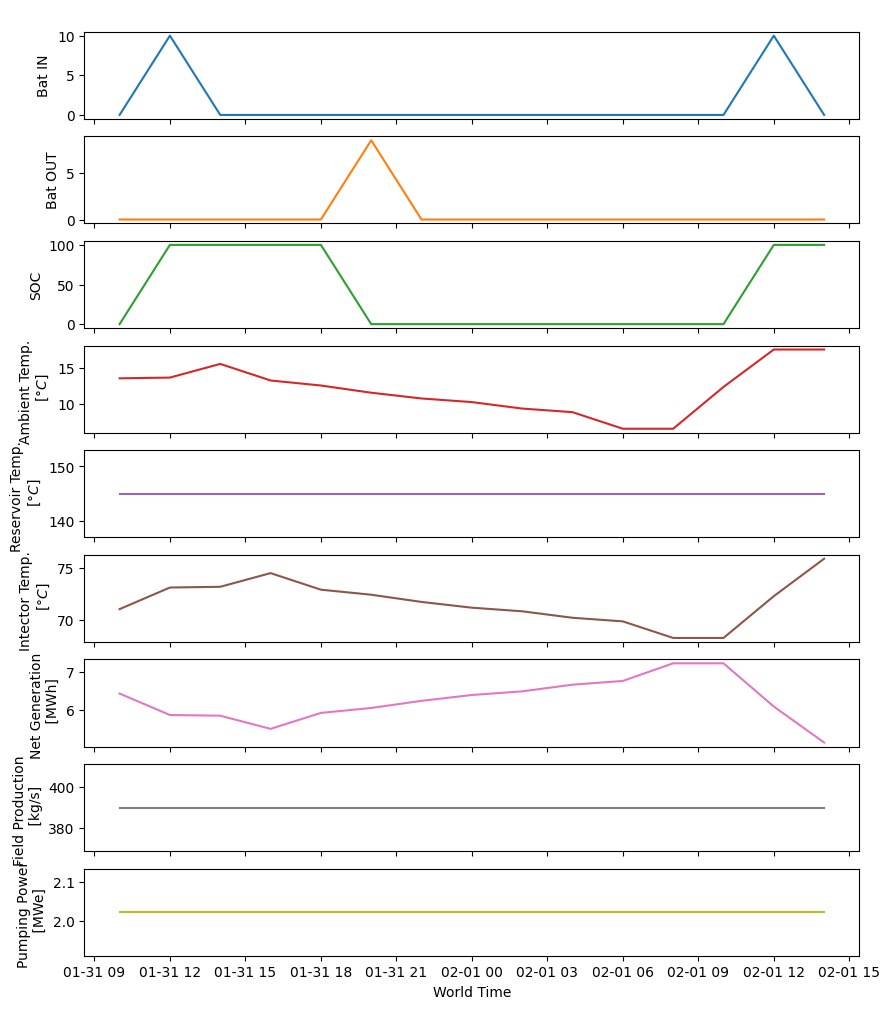

In [8]:
qdict = {
          "Bat Charge From PP [MWe]": "Bat IN",
          "Bat Discharge [MWe]": "Bat OUT",
          "SOC [%]": "SOC",
          "Atm Temp [deg C]": "Ambient Temp. \n [$\degree C$]",
          "Res Temp [deg C]": "Reservoir Temp. \n [$\degree C$]",
          'Inj Temp [deg C]': "Intector Temp. \n [$\degree C$]",
          "Net Power Output [MWe]": "Net Generation \n [MWh]",
          'M_Produced [kg/s]': "Field Production \n [kg/s]",
          "Pumping Power [MWe]": "Pumping Power \n [MWe]",
#           "WH Temp [deg C]": "Producer\nTemp. [$\degree C$]",
}

quantities = list(qdict.keys())
ylabels = list(qdict.values())

# span = range(365, project.max_simulation_steps-1)
span = range(365, 380)
fig, axes = plot_cols_v2({" ": project.df_records}, span, quantities, 
                         figsize=(10,12), ylabels=ylabels, legend_loc=False, dpi=100, 
                       formattime=False, return_figax=True)

In [2]:
import pandas as pd

In [15]:
df = pd.read_csv("./data/sample_project/reservoir.csv")
df["Date"] = pd.to_datetime(df["Date"])

In [18]:
df

,Date,Tres
0,2024-01-01,190.000
1,2024-01-02,189.995
2,2024-01-03,189.990
3,2024-01-04,189.985
4,2024-01-05,189.980
...,...,...
10502,2052-10-02,137.490
10503,2052-10-03,137.485
10504,2052-10-04,137.480
10505,2052-10-05,137.475
